## Objective

The timely prediction of abnormal oil production rate is the key to more proactive choke performance monitoring, leading to optimized well surviellance and hydrocarbon production.

Simply put, this artificial intelligence system aims to alert the petroleum production engineer of abnormal oil production rates, allowing them to apply industry standard well diagnostics to determine if it is a result of choke failure or a reservior condition that needs to be looked into.

#### Data Information
The data set used for this development consists of monthly well test data containing information about: choke size, fluid (oil, gas & water) volumes, fluid rates, hydrocarbon temperature and pressure at the well head and flowlines, and BS&W.

The following scenarios describe the data trend.

| Scenario | Narrative                                                                                                               | Implication                                                                               |   |   |
|----------|-------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------|---|---|
| 1        | Slight increase or reduction in oil rate, at same choke, slight increase or decrease in pressure                        | Normal                                                                                    |   |   |
| 2        | Reduction in oil rate, at a reduced choke size, increase in pressure                                                    | Normal                                                                                    |   |   |
| 3        | Significant (more than 150 bbls) and steady increase in oil rate, at same choke, and reduction in pressure up to 40psig | Abnormal trend – System should trigger a warning after the second month of similar trend. |   |   |
| 4        | Significant increase in oil rate, increased choke size, and reduced pressure                                            | Normal                                                                                    |   |   |

**Note**: For Abnormal trend in scenario 3, at the start of the trend, only 1 of the conditions narrated mmay be satisfied. This is okay and as the trend continues, all conditons will be satisfied.

Since the target value of the prediction is provided, it a supervised machine learning problem. Further analysis of the data set will show us the type of supervised learning problem we have.

In [1]:
# Import basic libraries for data wrangling, analysis and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load data set
well_data = pd.read_excel("Well Test data 2017 till data.xlsx")

In [3]:
well_data.columns

Index(['Start date', 'Choke Size', 'FTHP', 'FLP', 'FLT', 'Oil T', 'Gas T',
       'Gas P', 'Gas Diff', 'Oil Rate', 'Gas Rate', 'Water Rate', 'GOR', 'Oil',
       'Gas', 'Water', 'BSW', 'Remarks', 'Unnamed: 18'],
      dtype='object')

### Exploratoray Data Analysis (EDA)

In [4]:
# See what the data set looks like
well_data.head(10)

,Start date,Choke Size,FTHP,FLP,FLT,Oil T,Gas T,Gas P,Gas Diff,Oil Rate,Gas Rate,Water Rate,GOR,Oil,Gas,Water,BSW,Remarks,Unnamed: 18
0,NaT,"/64""",psig,psig,°F,°F,°F,psig,Inwg,bbls/d,mmscfd,bbls/d,scf/d,bbls,mmscf,bbls,%,NaN,NaN
1,2016-12-01,44,960,441.2,99.3,NaN,NaN,NaN,NaN,3245,3.1,39,1397.2,970,0.92,0.25,0.02,Normal trend,NaN
2,2017-09-01,44,950,500,113,105.8,102.1,119.5,81,3162.1,3.62,0.8,1144.5,791,1,0.2,0.02,Normal trend,NaN
3,2017-11-01,40,1060,460,104,0.43,95.42,85.8,71.85,2739.08,3.39,0.69,1238.5,684.49,0.85,0.171,0.03,Normal trend,NaN
4,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nodata,NaN
5,2018-01-01,44,950,560,116.6,109.4,107,120.4,65.92,3321.39,3.81,3.32,1146.9,830.35,0.95,0.83,0.1,Normal trend,NaN
6,2018-02-01,44,950,520,122,107.75,104.75,120,86.08,3324.95,4.2,3.19,1294.12,831.24,1.08,0.8,0.1,Normal trend,NaN
7,2018-04-01,44,930,515,114.8,103.25,100.4,120,74.25,3281.32,4.02,0.82,1225.23,820.33,1.01,0.21,0.025,Normal trend,NaN
8,2018-05-01,44,950,250,105.8,110.15,106.58,177.8,73.67,3191.92,3.94,0.78,1235.46,797.98,0.99,0.2,0.02,Normal trend,NaN
9,2018-06-01,44,940,300,114.8,95.6,114,210,62,3288.32,4.32,8.24,1314.58,822.08,1.08,2.06,0.25,Normal trend,NaN


Each column of the dataframe in the sample above contains the different variables of the data set, except for `Unnamed:18` which is apparently not a feature. It will be dropped.

The first row of the data set under the table header at index [0] contains the units of measurement of the variables, since this information does not affect the data analysis and model bulding it will be dropped. That is not to say that it is not of any use. At the software interface, the units of the expected input values will be indicated to avoid errors from inputing values of different magnitude from what the model expects due to difference in the units of measurement.

From an understanding of the project objective, `Remarks` column is the target value to be predicted. This is because well conditions are to be classified as normal or abnormal trends based on the different possible scenarios a producing well can depict (See Objective).

The data set contains several missing values represented as:

NaN - Not a Number

NaT - Not a Time for the DateTime column

In [5]:
# drop first row
well_data.drop(index=0, inplace=True)

well_data.head(5)

,Start date,Choke Size,FTHP,FLP,FLT,Oil T,Gas T,Gas P,Gas Diff,Oil Rate,Gas Rate,Water Rate,GOR,Oil,Gas,Water,BSW,Remarks,Unnamed: 18
1,2016-12-01,44,960,441.2,99.3,NaN,NaN,NaN,NaN,3245,3.1,39,1397.2,970,0.92,0.25,0.02,Normal trend,NaN
2,2017-09-01,44,950,500,113,105.8,102.1,119.5,81,3162.1,3.62,0.8,1144.5,791,1,0.2,0.02,Normal trend,NaN
3,2017-11-01,40,1060,460,104,0.43,95.42,85.8,71.85,2739.08,3.39,0.69,1238.5,684.49,0.85,0.171,0.03,Normal trend,NaN
4,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nodata,NaN
5,2018-01-01,44,950,560,116.6,109.4,107,120.4,65.92,3321.39,3.81,3.32,1146.9,830.35,0.95,0.83,0.1,Normal trend,NaN


In [6]:
# See information on the data set
well_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 1 to 50
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Start date   49 non-null     datetime64[ns]
 1   Choke Size   45 non-null     object        
 2   FTHP         45 non-null     object        
 3   FLP          45 non-null     object        
 4   FLT          45 non-null     object        
 5   Oil T        44 non-null     object        
 6   Gas T        44 non-null     object        
 7   Gas P        44 non-null     object        
 8   Gas Diff     44 non-null     object        
 9   Oil Rate     45 non-null     object        
 10  Gas Rate     45 non-null     object        
 11  Water Rate   45 non-null     object        
 12  GOR          45 non-null     object        
 13  Oil          45 non-null     object        
 14  Gas          45 non-null     object        
 15  Water        45 non-null     object        
 16  BSW       

The data set has 19 columns and 50 instances. All the columns contain several missing values. Machine learning models cannot be trained on data sets contain missing values. Looking at the data set closely it can be seen that these missing values are contained in certain rows that are completely empty and one particular column (`Unnamed: 18`) that is almost completely empty. The best line of action is to drop these rows and column as there isn't enough information to facilitate missing value replacement.

The values in the data set are of datetime and object data type. Since all the columns of object data type except the `Remarks` column contain numerical values in decimals, to reduce memory usage and fasten the runtime of the model to be built, it will be better to convert them to float.

In [7]:
# drop unnecessary additional column
well_data.drop(columns=['Unnamed: 18'], inplace=True)

well_data.sample(3, random_state=20)

,Start date,Choke Size,FTHP,FLP,FLT,Oil T,Gas T,Gas P,Gas Diff,Oil Rate,Gas Rate,Water Rate,GOR,Oil,Gas,Water,BSW,Remarks
13,2018-10-01,44,900,270,113,98,98,210,113,3306,4.6,0.8,1406.5,826.5,1.162,0.21,0.025,Abnormal occurrence
15,2018-12-01,44,880,250,120.2,103.1,107.166667,183.333333,91,3483.718333,4.885,0.87,1402.301667,870.929583,1.22125,0.2175,0.5,Abnormal occurrence
5,2018-01-01,44,950,560,116.6,109.4,107,120.4,65.92,3321.39,3.81,3.32,1146.9,830.35,0.95,0.83,0.1,Normal trend


In [8]:
# drop rows with missing values
well_data.dropna(axis=0, inplace=True)

well_data.shape

(44, 18)

The data set now has the shape (44, 18) meaning that there are 18 columns and 44 recorded instances for each column. 17 of the 18 columns are features to be used for predicting the target variable in the `Remarks` column which indicates if the oil production rate is normal or abnormal.

In [9]:
# Convert columns with Object data type to float

well_data['Choke Size'] = well_data['Choke Size'].astype(float, errors = 'raise')
well_data['FTHP'] = well_data['FTHP'].astype(float, errors = 'raise')
well_data['FLP'] = well_data['FLP'].astype(float, errors = 'raise')
well_data['FLT'] = well_data['FLT'].astype(float, errors = 'raise')
well_data['Oil T'] = well_data['Oil T'].astype(float, errors = 'raise')
well_data['Gas T'] = well_data['Gas T'].astype(float, errors = 'raise')
well_data['Gas P'] = well_data['Gas P'].astype(float, errors = 'raise')
well_data['Gas Diff'] = well_data['Gas Diff'].astype(float, errors = 'raise')
well_data['Oil Rate'] = well_data['Oil Rate'].astype(float, errors = 'raise')
well_data['Gas Rate'] = well_data['Gas Rate'].astype(float, errors = 'raise')
well_data['Water Rate'] = well_data['Water Rate'].astype(float, errors = 'raise')
well_data['GOR'] = well_data['GOR'].astype(float, errors = 'raise')
well_data['Oil'] = well_data['Oil'].astype(float, errors = 'raise')
well_data['Gas'] = well_data['Gas'].astype(float, errors = 'raise')
well_data['Water'] = well_data['Water'].astype(float, errors = 'raise')
well_data['BSW'] = well_data['BSW'].astype(float, errors = 'raise')

In [10]:
# See information on the data set
well_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 2 to 50
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Start date  44 non-null     datetime64[ns]
 1   Choke Size  44 non-null     float64       
 2   FTHP        44 non-null     float64       
 3   FLP         44 non-null     float64       
 4   FLT         44 non-null     float64       
 5   Oil T       44 non-null     float64       
 6   Gas T       44 non-null     float64       
 7   Gas P       44 non-null     float64       
 8   Gas Diff    44 non-null     float64       
 9   Oil Rate    44 non-null     float64       
 10  Gas Rate    44 non-null     float64       
 11  Water Rate  44 non-null     float64       
 12  GOR         44 non-null     float64       
 13  Oil         44 non-null     float64       
 14  Gas         44 non-null     float64       
 15  Water       44 non-null     float64       
 16  BSW         44 non-null     

Memory usage has been reduced by 2.3 KB, and there are no null values. The data set is now ready for statistical analysis and visualization.

In [11]:
well_data.shape

(44, 18)

In [12]:
# Get statistical distribution of the values
well_data.describe()

,Choke Size,FTHP,FLP,FLT,Oil T,Gas T,Gas P,Gas Diff,Oil Rate,Gas Rate,Water Rate,GOR,Oil,Gas,Water,BSW
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,43.545455,904.318182,287.840909,116.871818,102.308258,126.264015,167.105303,83.619015,3102.231106,4.172993,21.072414,1353.873956,772.364254,1.045617,5.269433,0.815341
std,1.284153,43.154548,84.532901,6.290788,16.505596,144.779453,25.334359,16.887547,345.145354,0.516666,69.858096,131.721045,85.198902,0.127229,17.466974,2.705722
min,40.000000,830.000000,200.000000,88.000000,0.430000,67.000000,85.800000,57.300000,2221.000000,2.800000,0.000000,1144.500000,555.200000,0.702000,0.000000,0.000000
25%,44.000000,880.000000,250.000000,115.225000,102.650000,105.087500,160.000000,72.750000,2864.625000,3.900000,0.710493,1238.121905,716.165000,0.987250,0.182237,0.025000
50%,44.000000,900.000000,260.000000,118.200000,104.591667,107.083333,170.000000,80.833333,3174.800000,4.211150,0.824914,1345.137339,792.085000,1.054500,0.210000,0.025000
75%,44.000000,940.000000,280.000000,120.250000,108.000000,108.075000,180.000000,88.850000,3307.533142,4.456000,1.525000,1409.625000,823.185000,1.111750,0.375000,0.050000
max,44.000000,1060.000000,560.000000,123.000000,114.600000,1063.000000,210.000000,133.000000,3857.111094,5.012800,343.900000,1710.600000,964.277773,1.253000,86.000000,13.000000


The magnitude of the variables range from units to thousands, this will not be problematic for the types of algorithms to be used for model building to learn from.
The standard deviations show that the values may not be normally distributed, visualization using histogram plots will show us what the data distributions look like.

In [13]:
# Get statistical  description for categorical values
well_data.describe(include=['object'])

,Remarks
count,44
unique,2
top,Normal trend
freq,31


In [14]:
well_data['Remarks'].unique()

array(['Normal trend', 'Abnormal occurrence'], dtype=object)

The target variable has 2 unique values. Therefore, this is a binary classification problem. Classification algorithms will be used for model training starting with a simple supervised learning algorithm like Logistic regression.

There is also a high level of class imbalance with 31 data points for `Normal trend` and 44 minus 31 which is only 13 in the `Abnormal occurence` class. This will be taken into account in choosing a suitable model evaluation metric.

Machine learning algorithms can only compute numerical data, so the classes mentioned above will be numerically encoded in the next cell.

In [65]:
# Encode categorical data
well_data['Remarks'].replace('Normal trend', 0, inplace=True)

well_data['Remarks'].replace('Abnormal occurrence', 1, inplace=True)

In [15]:
well_data.sample(3, random_state=10)

,Start date,Choke Size,FTHP,FLP,FLT,Oil T,Gas T,Gas P,Gas Diff,Oil Rate,Gas Rate,Water Rate,GOR,Oil,Gas,Water,BSW,Remarks
29,2020-02-01,44.0,900.0,260.0,120.5,110.9,111.0,160.0,80.666667,3101.6334,4.138877,0.775602,1334.429099,775.40835,1.034719,0.193901,0.025,Normal trend
13,2018-10-01,44.0,900.0,270.0,113.0,98.0,98.0,210.0,113.000000,3306.0000,4.600000,0.800000,1406.500000,826.50000,1.162000,0.210000,0.025,Abnormal occurrence
31,2020-04-01,44.0,900.0,250.0,118.0,109.7,108.0,170.0,74.200000,2854.4000,4.100000,0.700000,1433.200000,713.60000,1.023000,0.180000,0.025,Normal trend


The categorical values in the `Remarks` column have been replaced with numerals. When outputing model predictions to end users, the predictions will be converted back to be human interpretable.

`Start date` has no real relevance to the prediction target as it is only an index (like a serial number), what is really being taken account is the changes in the petrophysical properties and hydrocarbon quantities; it will be dropped.

In [16]:
well_data.drop(columns=['Start date'], inplace=True)

In [17]:
well_data.shape

(44, 17)

In [18]:
# Get data correlation
well_data.corr()

,Choke Size,FTHP,FLP,FLT,Oil T,Gas T,Gas P,Gas Diff,Oil Rate,Gas Rate,Water Rate,GOR,Oil,Gas,Water,BSW
Choke Size,1.000000,0.053029,0.063589,-0.076471,0.351152,0.069898,0.257130,0.299173,0.665653,0.704528,-0.788184,0.198239,0.660407,0.712891,-0.788112,-0.793362
FTHP,0.053029,1.000000,0.528870,-0.499067,-0.537770,-0.010898,-0.425420,-0.280697,0.009130,0.047159,-0.247036,0.043919,0.030519,0.074246,-0.246981,-0.258594
FLP,0.063589,0.528870,1.000000,-0.171945,-0.311216,-0.077746,-0.626468,-0.109084,0.237171,-0.088210,-0.248563,-0.359304,0.243908,-0.027097,-0.248554,-0.252926
FLT,-0.076471,-0.499067,-0.171945,1.000000,0.311727,0.023960,0.034294,0.150704,0.005658,0.017047,0.204274,0.069695,-0.031463,0.009117,0.204254,0.212079
Oil T,0.351152,-0.537770,-0.311216,0.311727,1.000000,0.052506,0.351129,0.016132,0.025332,0.107501,0.145113,0.123627,0.025166,0.109100,0.145142,0.146296
Gas T,0.069898,-0.010898,-0.077746,0.023960,0.052506,1.000000,0.023875,0.016361,-0.143957,0.103243,-0.040153,0.305634,-0.140938,0.090148,-0.040194,-0.040717
Gas P,0.257130,-0.425420,-0.626468,0.034294,0.351129,0.023875,1.000000,0.249994,0.296993,0.423716,-0.041515,0.205183,0.281258,0.387621,-0.041512,-0.043600
Gas Diff,0.299173,-0.280697,-0.109084,0.150704,0.016132,0.016361,0.249994,1.000000,0.384879,0.500296,-0.302463,0.255251,0.352449,0.508426,-0.302510,-0.299576
Oil Rate,0.665653,0.009130,0.237171,0.005658,0.025332,-0.143957,0.296993,0.384879,1.000000,0.718182,-0.636736,-0.139711,0.969565,0.735850,-0.636714,-0.637241
Gas Rate,0.704528,0.047159,-0.088210,0.017047,0.107501,0.103243,0.423716,0.500296,0.718182,1.000000,-0.624798,0.556366,0.665588,0.992478,-0.624763,-0.625615


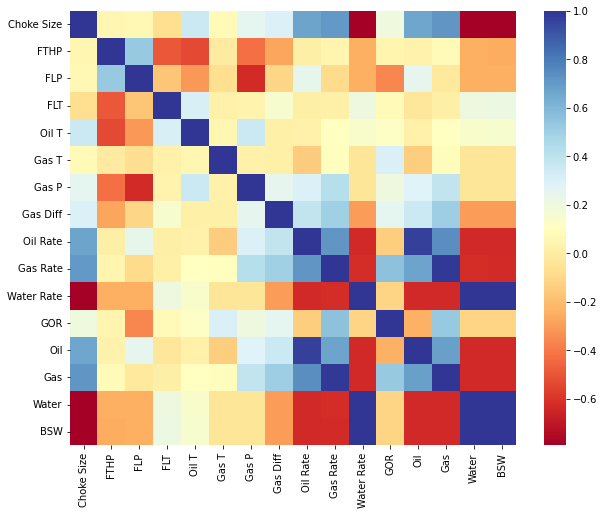

In [19]:
# Plot correlartion
fig, ax = plt.subplots(figsize=(10,8))

sns.heatmap(well_data.corr(), cmap='RdYlBu')

plt.show()

From the correlation heatmap in the plot above and the correlation values in the table, `water` is very highly correlated with `BSW` with a correlation of approximately one. What this shows is that the correlated features share similar statistical properties and have similar impact on the prediction target, this leads to what is called multicollinearity. Multicollinearity reduces the precision of the weight coefficients in linear models, which weakens the statistical power of a regression model.

All the features have varying magnitudes of high enough negative and positive correlation with the target variable `Remarks`, this implies that they are all relevant in predicting it. 

I will consider dropping the features causing multicollinearity during the feature engineering phase.

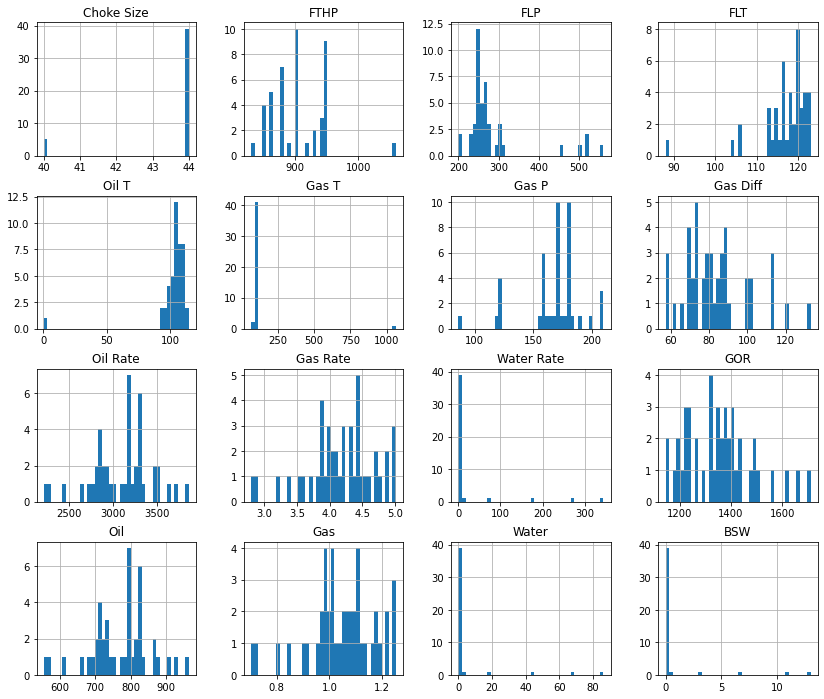

In [20]:
# Plotting to check the statitistical distribution of the variables
well_data.hist(figsize=(14,12), bins=40);

As observed earlier, the variables in data set are not all normally distributed. Looking at the histograms each variable:
BSW is left-skewed

FTHP - left-skewed 

FLP - left-skewed

FLT - right-skewed

Oil - normally distributed

Gas - almost normal distribution

Gas P - right-skewed

Gas Diff - normal distribution

Oil Rate - normal distribution

Gas Rate - right-skewed

Water Rate - left-skewed

GOR - normal distribution

Water         left-skewed

The features of the data set may be skewed to one side as a result of outliers present, a boxplot will help us verify this.

Choke Size has two values of which most of the data points fall at the value 44 /64", from technical knowledge of well production, this is not an abnormality and so does not need to normalized.

`Oil T` and `Gas T` have what looks like outlier values that are very close to 0 and 1000 respectively and far from the prevailing range of values seen at other data points. A boxplot of these features will verify the presence of outliers.


The distribution of the data points in `Remarks` shows the binary classes which are clearly imbalanced.

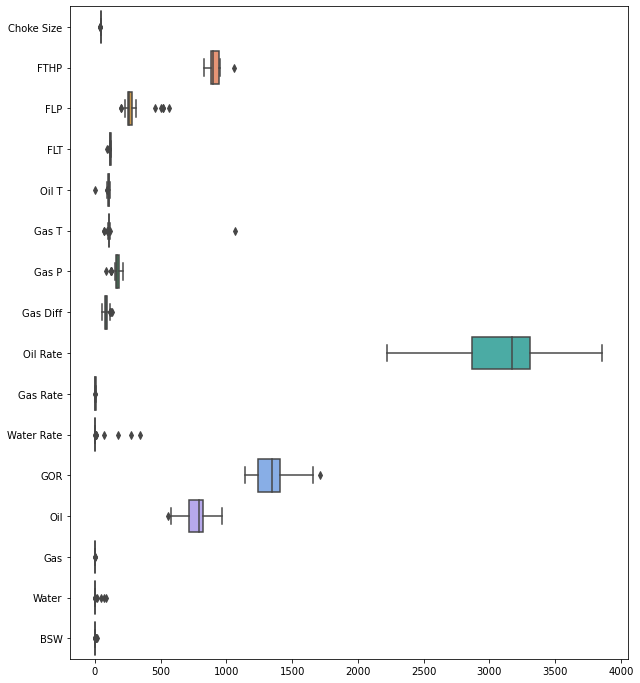

In [21]:
# Boxplot for the entire data set to check for outliers

fig, ax = plt.subplots(figsize=(10,12))

sns.boxplot(data=well_data, ax=ax, orient='h')

plt.show()

There are outliers and since the data set is a small one, instead of dropping them, the will be replaced with the average of the features.

### Feature Engineering

In [22]:
well_data.columns

Index(['Choke Size', 'FTHP', 'FLP', 'FLT', 'Oil T', 'Gas T', 'Gas P',
       'Gas Diff', 'Oil Rate', 'Gas Rate', 'Water Rate', 'GOR', 'Oil', 'Gas',
       'Water', 'BSW', 'Remarks'],
      dtype='object')

In [23]:
# replace outliers with null values

# for FTHP
for x in ['FTHP']:
    Q75,Q25 = np.percentile(well_data.loc[:,x], [75,25])
    IQR = Q75-Q25
    
    max = Q75 + (1.5*IQR)
    min = Q25 - (1.5*IQR)
    
    well_data.loc[well_data[x] < min,x] = np.nan
    well_data.loc[well_data[x] > max,x] = np.nan
    
# for FLP
for x in ['FLP']:
    Q75,Q25 = np.percentile(well_data.loc[:,x], [75,25])
    IQR = Q75-Q25
    
    max = Q75 + (1.5*IQR)
    min = Q25 - (1.5*IQR)
    
    well_data.loc[well_data[x] < min,x] = np.nan
    well_data.loc[well_data[x] > max,x] = np.nan  
    
# for FLT
for x in ['FLT']:
    Q75,Q25 = np.percentile(well_data.loc[:,x], [75,25])
    IQR = Q75-Q25
    
    max = Q75 + (1.5*IQR)
    min = Q25 - (1.5*IQR)
    
    well_data.loc[well_data[x] < min,x] = np.nan
    well_data.loc[well_data[x] > max,x] = np.nan
        
# for Oil T
for x in ['Oil T']:
    Q75,Q25 = np.percentile(well_data.loc[:,x], [75,25])
    IQR = Q75-Q25
    
    max = Q75 + (1.5*IQR)
    min = Q25 - (1.5*IQR)
    
    well_data.loc[well_data[x] < min,x] = np.nan
    well_data.loc[well_data[x] > max,x] = np.nan  
    
# for Gas T
for x in ['Gas T']:
    Q75,Q25 = np.percentile(well_data.loc[:,x], [75,25])
    IQR = Q75-Q25
    
    max = Q75 + (1.5*IQR)
    min = Q25 - (1.5*IQR)
    
    well_data.loc[well_data[x] < min,x] = np.nan
    well_data.loc[well_data[x] > max,x] = np.nan
    
# for Gas p 
for x in ['Gas P']:
    Q75,Q25 = np.percentile(well_data.loc[:,x], [75,25])
    IQR = Q75-Q25
    
    max = Q75 + (1.5*IQR)
    min = Q25 - (1.5*IQR)
    
    well_data.loc[well_data[x] < min,x] = np.nan
    well_data.loc[well_data[x] > max,x] = np.nan
    
# for Gas
for x in ['Gas']:
    Q75,Q25 = np.percentile(well_data.loc[:,x], [75,25])
    IQR = Q75-Q25
    
    max = Q75 + (1.5*IQR)
    min = Q25 - (1.5*IQR)
    
    well_data.loc[well_data[x] < min,x] = np.nan
    well_data.loc[well_data[x] > max,x] = np.nan

In [24]:
# replace outliers with null values

# for Gas Diff
for x in ['Gas Diff']:
    Q75,Q25 = np.percentile(well_data.loc[:,x], [75,25])
    IQR = Q75-Q25
    
    max = Q75 + (1.5*IQR)
    min = Q25 - (1.5*IQR)
    
    well_data.loc[well_data[x] < min,x] = np.nan
    well_data.loc[well_data[x] > max,x] = np.nan
    
# for Water Rate
for x in ['Water Rate']:
    Q75,Q25 = np.percentile(well_data.loc[:,x], [75,25])
    IQR = Q75-Q25
    
    max = Q75 + (1.5*IQR)
    min = Q25 - (1.5*IQR)
    
    well_data.loc[well_data[x] < min,x] = np.nan
    well_data.loc[well_data[x] > max,x] = np.nan  
    
# for GOR
for x in ['GOR']:
    Q75,Q25 = np.percentile(well_data.loc[:,x], [75,25])
    IQR = Q75-Q25
    
    max = Q75 + (1.5*IQR)
    min = Q25 - (1.5*IQR)
    
    well_data.loc[well_data[x] < min,x] = np.nan
    well_data.loc[well_data[x] > max,x] = np.nan
        
# for Oil
for x in ['Oil']:
    Q75,Q25 = np.percentile(well_data.loc[:,x], [75,25])
    IQR = Q75-Q25
    
    max = Q75 + (1.5*IQR)
    min = Q25 - (1.5*IQR)
    
    well_data.loc[well_data[x] < min,x] = np.nan
    well_data.loc[well_data[x] > max,x] = np.nan  
    
# for water
for x in ['Water']:
    Q75,Q25 = np.percentile(well_data.loc[:,x], [75,25])
    IQR = Q75-Q25
    
    max = Q75 + (1.5*IQR)
    min = Q25 - (1.5*IQR)
    
    well_data.loc[well_data[x] < min,x] = np.nan
    well_data.loc[well_data[x] > max,x] = np.nan
    
# for BSW 
for x in ['BSW']:
    Q75,Q25 = np.percentile(well_data.loc[:,x], [75,25])
    IQR = Q75-Q25
    
    max = Q75 + (1.5*IQR)
    min = Q25 - (1.5*IQR)
    
    well_data.loc[well_data[x] < min,x] = np.nan
    well_data.loc[well_data[x] > max,x] = np.nan
    
# for Gas Rate 
for x in ['Gas Rate']:
    Q75,Q25 = np.percentile(well_data.loc[:,x], [75,25])
    IQR = Q75-Q25
    
    max = Q75 + (1.5*IQR)
    min = Q25 - (1.5*IQR)
    
    well_data.loc[well_data[x] < min,x] = np.nan
    well_data.loc[well_data[x] > max,x] = np.nan

In [25]:
# Check number outliers replaced by null values in data set
well_data.isnull().sum()

Choke Size    0
FTHP          1
FLP           7
FLT           4
Oil T         3
Gas T         9
Gas P         6
Gas Diff      4
Oil Rate      0
Gas Rate      2
Water Rate    9
GOR           1
Oil           1
Gas           3
Water         9
BSW           9
Remarks       0
dtype: int64

In [26]:
# Replace all null values (formerly outliers) with mean
well_data = well_data.fillna(well_data.mean())

C:\Users\HP\AppData\Local\Temp\ipykernel_2740\432963558.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  well_data = well_data.fillna(well_data.mean())


In [27]:
well_data.isnull().sum()

Choke Size    0
FTHP          0
FLP           0
FLT           0
Oil T         0
Gas T         0
Gas P         0
Gas Diff      0
Oil Rate      0
Gas Rate      0
Water Rate    0
GOR           0
Oil           0
Gas           0
Water         0
BSW           0
Remarks       0
dtype: int64

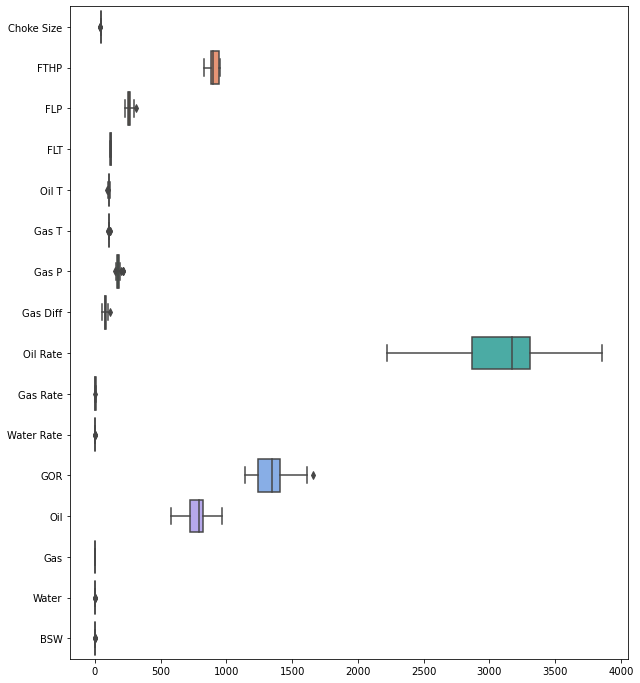

In [28]:
# Boxplot for the entire data set to check for outliers

fig, ax = plt.subplots(figsize=(10,12))

sns.boxplot(data=well_data, ax=ax, orient='h')

plt.show()

#### Train-test Split

Machine learning models have to be trained on a large fraction of a data set for the relationship between the variables to be accurately modeled. 

After that, the performance of the model has to be tested on data points previously unseen by the data. This why the data is being split into training and testing data.

Using train_test_split from scikit learn library, we divde into training and test set in the 80:20.

In [29]:
# train-test split
from sklearn.model_selection import train_test_split

# Define features
X = well_data.drop(columns=['Remarks'], axis=1)

# Define target
y = well_data['Remarks']

# Split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [30]:
# Standardize training features

from sklearn.preprocessing import scale

X_train2 = scale(X_train)

X_train2

array([[ 3.06186218e-01, -6.09337810e-01, -6.15241221e-01,
         6.46110069e-01, -5.35638575e-01, -8.06262448e-02,
         5.48864457e-01,  1.04214598e+00,  1.25976264e+00,
         1.62841223e+00, -1.89709571e-02,  4.24996961e-01,
         1.33652513e+00,  1.74319671e+00, -3.52956813e-02,
         5.45063924e-02],
       [ 3.06186218e-01,  1.30460788e+00,  3.81482024e-02,
         1.30762396e+00,  5.09006155e-01, -1.35339879e+00,
        -5.36762643e-03,  6.27544062e-01,  7.56808995e-01,
        -1.50410022e-01, -5.72755072e-02, -5.50352507e-01,
         7.66597615e-01,  8.72451222e-02, -5.87867904e-02,
         5.45063924e-02],
       [ 3.06186218e-01, -3.35916998e-01, -6.15241221e-01,
        -8.97422347e-01, -4.68242141e-01,  3.58260841e-01,
        -2.68553903e-01, -7.86484428e-01, -2.78918295e-01,
        -6.69774183e-01, -6.12792187e-01, -2.67435196e-01,
        -4.07158099e-01, -9.32703820e-01, -4.28848597e-01,
        -3.17732385e-01],
       [-3.26598632e+00, -1.97644187e

In [31]:
# Normalize the features

from sklearn.preprocessing import normalize

X_train3 = normalize(X_train)

X_train3

array([[1.10769129e-02, 2.21538258e-01, 6.29370052e-02, 3.02601121e-02,
        2.59552209e-02, 2.69789962e-02, 4.61538038e-02, 2.29090699e-02,
        8.77019195e-01, 1.22978908e-03, 2.19020778e-04, 3.53026669e-01,
        2.19254799e-01, 3.07447270e-04, 5.47551945e-05, 7.15683659e-06],
       [1.15669449e-02, 2.49740856e-01, 6.89895792e-02, 3.20719836e-02,
        2.83258708e-02, 2.75372154e-02, 4.61220398e-02, 2.26291504e-02,
        8.74079851e-01, 1.10411747e-03, 2.25827280e-04, 3.40204880e-01,
        2.18520620e-01, 2.83915920e-04, 5.67459936e-05, 7.47344817e-06],
       [1.25799792e-02, 2.54458670e-01, 7.14771546e-02, 3.31653997e-02,
        2.95629511e-02, 3.08781308e-02, 4.90905098e-02, 1.98134673e-02,
        8.57154038e-01, 1.14363447e-03, 2.00136033e-04, 3.78971874e-01,
        2.14288510e-01, 2.83907258e-04, 5.43226375e-05, 7.14771546e-06],
       [1.36981607e-02, 2.84236835e-01, 8.04766944e-02, 4.17793903e-02,
        3.56152179e-02, 3.60261627e-02, 5.82171832e-02, 1.962

### Model Building and Evaluation

I will be experimenting the model building with 3 different classification algorithms: Logistic regression, Decision tree , and RandomForest algorithms. The best performing models will be taken to production.

Machine learning models need to be evaluated to determine their performance. Evaluation metrics are mathematical equations that evaluate the performance of the model by comparing the model's predictions to the actual recorded values.To evaluate the model, we take the accuracy score which is a measure of a model's percentage of accurate predictions.

Where:
        0 = Normal trend
        1 = Abnormal occurence

In [32]:
X_train.shape

(35, 16)

35 data points are being used for model training while the remaining 9 will be for testing.

In [33]:
# Import evaluation metric
from sklearn.metrics import accuracy_score

In [34]:
# Function for data building and evaluation

def build_model(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    
    # Fit training data
    model.fit(X_train, y_train)

    # Make training prediction
    train_pred = model.predict(X_train)
    
    # Make test prediction
    y_pred = model.predict(X_test)

    # Evaluate model using accuracy_score
    train_accuracy = round(100 * accuracy_score(y_true=y_train, y_pred=train_pred), 2)
    test_accuracy = round(100 * accuracy_score(y_true=y_test, y_pred=y_pred), 2)
    
    print('Model training accuracy score: {}%'. format(train_accuracy))
    print('Model training accuracy score: {}%'. format(test_accuracy))

    comparison_df = pd.DataFrame({'Remarks_actual': y_test, 'Remarks_predicted': y_pred})
    # print samples to see our model prediction
    print('\n')
    print(comparison_df)


    return 
    

#### Logistic Regression Model

In [39]:
# import logistic regression algorithm and instantiate
from sklearn.linear_model import LogisticRegression

log1 = LogisticRegression(max_iter=200)

log1

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
build_model(model=log1)

Model training accuracy score: 100.0%
Model training accuracy score: 100.0%


    Remarks_actual  Remarks_predicted
34               0                  0
7                0                  0
3                0                  0
21               1                  1
31               0                  0
47               0                  0
17               1                  1
20               1                  1
2                0                  0


This model trained on the original data set having a performance of 100% is overfitting on both trainging and test data. 100% is not an optimal score.

In [41]:
log2 = LogisticRegression(max_iter=200)

build_model(model=log2, X_train=X_train2)

Model training accuracy score: 100.0%
Model training accuracy score: 33.33%


    Remarks_actual  Remarks_predicted
34               0                  1
7                0                  1
3                0                  1
21               1                  1
31               0                  1
47               0                  1
17               1                  1
20               1                  1
2                0                  1


The logistic regression built on the standardized training data set performs poorly on the test data set and overfits the training set. 

In [42]:
log2 = LogisticRegression(max_iter=200)

build_model(model=log2, X_train=X_train3)

Model training accuracy score: 71.43%
Model training accuracy score: 77.78%


    Remarks_actual  Remarks_predicted
34               0                  0
7                0                  1
3                0                  0
21               1                  1
31               0                  0
47               0                  0
17               1                  1
20               1                  1
2                0                  1


The Logistic regression model built on the normalized training features performs better than the it's counterparts and doesn't overfit.

#### Decision Tree model

In [43]:
# import logistic regression algorithm and instantiate
from sklearn.tree import DecisionTreeClassifier

# Instantiate model
tree1 = DecisionTreeClassifier(min_samples_split=18, random_state=20)

build_model(model=tree1)

Model training accuracy score: 80.0%
Model training accuracy score: 88.89%


    Remarks_actual  Remarks_predicted
34               0                  0
7                0                  1
3                0                  0
21               1                  1
31               0                  0
47               0                  0
17               1                  1
20               1                  1
2                0                  0


The Decision tree model built on the original training features is a promising performance and does not overfit.

In [44]:
# Instantiate model
tree2 = DecisionTreeClassifier(min_samples_split=18, random_state=20)

build_model(model=tree2, X_train=X_train2)

Model training accuracy score: 80.0%
Model training accuracy score: 33.33%


    Remarks_actual  Remarks_predicted
34               0                  1
7                0                  1
3                0                  1
21               1                  1
31               0                  1
47               0                  1
17               1                  1
20               1                  1
2                0                  1


The Decision tree model built on the standardized training features is overfitting.

In [45]:
# Instantiate model
tree3 = DecisionTreeClassifier(min_samples_split=18, random_state=20)

build_model(model=tree3, X_train=X_train3)

Model training accuracy score: 97.14%
Model training accuracy score: 66.67%


    Remarks_actual  Remarks_predicted
34               0                  0
7                0                  0
3                0                  0
21               1                  0
31               0                  0
47               0                  0
17               1                  0
20               1                  0
2                0                  0


The Decision tree model built on the normalized training features overfits

 #### RandomForest Model

In [35]:
#  Import algorithm from scikit learn library
from sklearn.ensemble import RandomForestClassifier

# Instantiate model
r_forest1 = RandomForestClassifier(min_samples_split=21, max_depth=2, n_estimators=100, random_state=20)

build_model(model=r_forest1)

Model training accuracy score: 85.71%
Model training accuracy score: 88.89%


         Remarks_actual    Remarks_predicted
34         Normal trend         Normal trend
7          Normal trend         Normal trend
3          Normal trend         Normal trend
21  Abnormal occurrence  Abnormal occurrence
31         Normal trend         Normal trend
47         Normal trend         Normal trend
17  Abnormal occurrence         Normal trend
20  Abnormal occurrence  Abnormal occurrence
2          Normal trend         Normal trend


The RandomForest model built on the original training features is a promising model. Let's see if we can get a better performance from the other models.

In [36]:
# Instantiate model
r_forest2 = RandomForestClassifier(min_samples_split=21, max_depth=2, n_estimators=100, random_state=20)

build_model(model=r_forest2, X_train=X_train2)

Model training accuracy score: 85.71%
Model training accuracy score: 33.33%


         Remarks_actual    Remarks_predicted
34         Normal trend  Abnormal occurrence
7          Normal trend  Abnormal occurrence
3          Normal trend  Abnormal occurrence
21  Abnormal occurrence  Abnormal occurrence
31         Normal trend  Abnormal occurrence
47         Normal trend  Abnormal occurrence
17  Abnormal occurrence  Abnormal occurrence
20  Abnormal occurrence  Abnormal occurrence
2          Normal trend  Abnormal occurrence


C:\Users\HP\anaconda3_new\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


The RandomForest model built on the standardized training features is overfitting the training data.

In [37]:
# Instantiate model
r_forest3 = RandomForestClassifier(min_samples_split=21, max_depth=2, n_estimators=100, random_state=20)

build_model(model=r_forest3, X_train=X_train3)

Model training accuracy score: 97.14%
Model training accuracy score: 66.67%


         Remarks_actual Remarks_predicted
34         Normal trend      Normal trend
7          Normal trend      Normal trend
3          Normal trend      Normal trend
21  Abnormal occurrence      Normal trend
31         Normal trend      Normal trend
47         Normal trend      Normal trend
17  Abnormal occurrence      Normal trend
20  Abnormal occurrence      Normal trend
2          Normal trend      Normal trend


C:\Users\HP\anaconda3_new\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


The RandomForest model built on the normalized training features overfits the training data set.

**The model with the best performance is the RandomForest model built on the original training features.** 

**It has a training accuracy score of: 85.71%**

**And test accuracy score of: 88.89%**

A confusion matrix is table that is used to define the performance of a classification algorithm visually. It can be added to the Results & Disccusion chapter of the technical report along with the table comparing the predicted value of `Remarks` with the actual values.

Where:
TN = True Negative
TP = True Positive
FN = False Negative
FP = False Postives

True Negative represents the number of recorded negative values (in this case, `normal trend` represented as`0`) for the classification target variable (`Remarks` in this case) that are correctly predicted as positive the Learning model.

True Positive represents the number of recorded/actual positive value in a binary classification problem that are correctly predicted as positive by the model.

False Negative represents the number of recorded positive values that are wrongly classified as negative the machine learning model.

False Positive represents the number of actual negative values in a binary classification problem that are falsely classified as positive by the model.

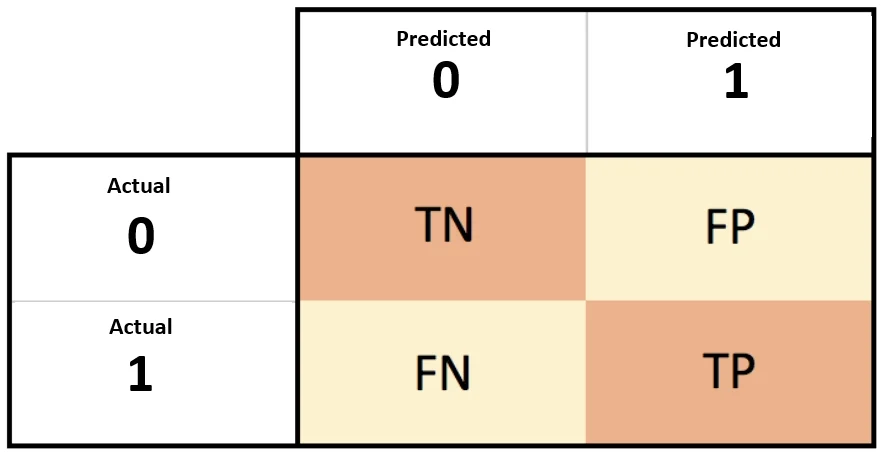

Figure: Basic representation of a confusion matrix. Source: [Author](https://subscription.packtpub.com/book/data/9781838555078/6/ch06lvl1sec34/confusion-matrix)


The cofusion matrix of the highest performing model which is the `r_forest1` is plotted below.

C:\Users\HP\anaconda3_new\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


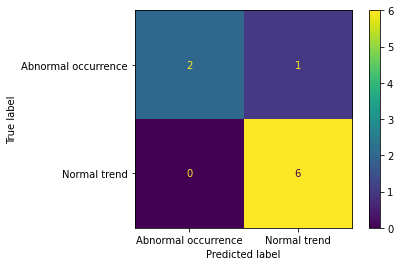

In [38]:
# Plot Confusion matrix
from sklearn.metrics import plot_confusion_matrix

#Get the confusion matrix
plot_confusion_matrix(r_forest1, X_test, y_test)  

plt.show()

The model has 0 false prediction for both the negative and positive outcomes. Perfect!

The confusion matrix shows that out of the 9 data points that were used to test the model, the 6 negative outcomes (`normal trend`) were correctly classified as True Negatives (TN). While, 2 of the positive outcome (`Abnormal trend`) where correctly classified and 1 was wrongly classified (i.e. 1 FN)

The model performance is fair enough but can be improved with the provision of more data.

### Model Deployment

In [39]:
# Save model as pickle file
import pickle

pickle.dump(r_forest1, open('model.pkl', 'wb'))